# PyTorch Tutorial: Simulating the Sine Function with a Simple Neural Network
This tutorial will guide you through creating a simple neural network using PyTorch to approximate the sine function.

In [1]:
import torch                                          # Import PyTorch, a deep learning framework
import torch.nn as nn                                 # Import PyTorch's neural network module
import torch.optim as optim                           # Import PyTorch's optimization module
from torch.utils.data import DataLoader, TensorDataset  # Import utilities for creating data loaders and datasets
from tqdm import tqdm                                 # Import tqdm for progress visualization
import numpy as np                                    # Import NumPy, a library for numerical operations
import matplotlib.pyplot as plt                       # Import Matplotlib for plotting

Data generated is in range: $[-2\pi, 2\pi]$

Before data could be used by pytorch it should be converted to tensor by `torch.Tensor()`.

Because data is one-dimensional it is interpreted as a single sample of size 1000. We need to have 1000 samples of size 1. To achieve that we add one more dimension to data using `.unsqueeze(1)` on tensor.

In [2]:
# Generate data
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000) # generate 1000 intermediate values equally spaced (input values)
y = np.sin(x) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_tensor = torch.Tensor(x).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)
y_tensor = torch.Tensor(y).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)

Creating a model. For model we will use a custom class derived from `nn.Module`. In constructor `__init__` we define all layers we want to use.

In `forward` method we perform connection of defined layers.

In [3]:
class SineNet(nn.Module):
    def __init__(self): # constructor
        super(SineNet, self).__init__()
        # In pytorch we need to explicitly state number of inputs and outputs for layer
        self.hidden1 = nn.Linear(1, 50) # one input and 50 outputs (neurons)
        self.hidden2 = nn.Linear(50, 25) # 50 inputs and 25 outputs (neurons)
        self.output = nn.Linear(25, 1) # 25 inputs and one output (neuron)
        self.relu = nn.ReLU() # ReLU activation function
    
    def forward(self, x): # forward method to propagate signals through network
        x = self.relu(self.hidden1(x)) # send input signal through hidden1() layer, then apply relu() function
        x = self.relu(self.hidden2(x)) # send output of previous layer through hidden2() layer, then apply relu() function
        x = self.output(x) # use result of previous operation as input to output layer (it has no activation function)
        return x

# Instantiate the model (from class create an object)
model = SineNet()

`torch.optim.Adam` - Adam optimizer determines how to adjust weights based on accumulated loss gradients.

`torch.nn.MSELoss()` - Mean Squared Error (L2) loss used calculate error between model output and expected output.

`model.parameters()` - are model weights which will be adjusted by optimizer.

In [4]:
criterion = nn.MSELoss() # We use MSE (L2) for error calculation
optimizer = optim.Adam(model.parameters(), lr=0.01) # `model.parameters()` - model weights, lr - learning rate (set to 0.01)

Here we will train our model for 1000 epochs, adjusting weights once per epoch.

This approach is not good for complex data as it would be difficult for model to start converging when weights adjusted after all samples were provided, because accumulated gradients for each weight may be very close to zero. Much better approach is to adjust weights after a batch of samples, which we will discuss later.

`model.train()` - switch model to training state. In training state some layers related to batch normalization and dropout are active or change their behavior. For example: `torch.nn.Dropout`, `torch.nn.BatchNorm1d`, `torch.nn.BatchNorm2d`, `torch.nn.BatchNorm3d`.

For normal model usage (inference only) after training, always swith model to `model.eval()` and disable gradients calculation `torch.no_grad()`. This will ensure that outputs of model are consistent, that model takes less memory and calculations are faster.

Every time we do `loss.backward()` we pass the loss (error) through all weights and calculate the gradients of loss - how much effect each weight had on error. Then those values are added for each weight to previous from `.backward()` pass.

`optimizer.zero_grad()` used to avoid accumulation of gradients of loss, in our case, before each epoch we do  to set accumulated gradients for each weight to 0.

`optimizer.step()` performs adjustment of weights based on accumulated gradients.

In [7]:
# Training loop
epochs = 1000
losses = [] # we will store losses from each epoch here for visualization purposes

for epoch in range(epochs):
    model.train() # Switch model to training mode (enables dropout, changes batchnorm behavior)
    
    # Forward pass
    outputs = model(x_tensor) # Propagate input `x_tensor` through the model to get outputs
    loss = criterion(outputs, y_tensor) # Calculate the loss (error) by comparing model outputs to the true values `y_tensor`
    
    # Backward pass and optimization
    optimizer.zero_grad() # Clear the gradients of all optimized tensors
    loss.backward() # Compute the gradient of the loss with respect to model parameters
    optimizer.step() # Update model parameters (weights and biases) using the optimizer
    
    losses.append(loss.item()) # Store the loss value for later analysis
    
    if (epoch + 1) % 100 == 0: # Print progress every 100 epochs (epochs count start from 0, so we add 1 for visualization)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [100/1000], Loss: 0.0003
Epoch [200/1000], Loss: 0.0004
Epoch [300/1000], Loss: 0.0002
Epoch [400/1000], Loss: 0.0003
Epoch [500/1000], Loss: 0.0002
Epoch [600/1000], Loss: 0.0022
Epoch [700/1000], Loss: 0.0002
Epoch [800/1000], Loss: 0.0003
Epoch [900/1000], Loss: 0.0002
Epoch [1000/1000], Loss: 0.0002


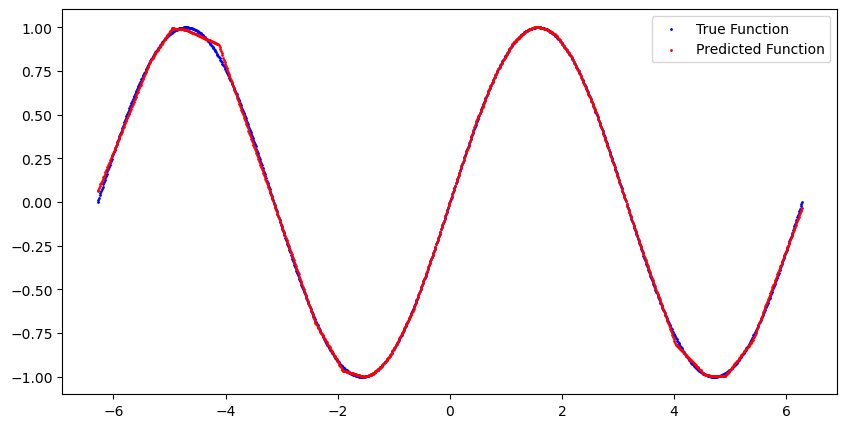

In [8]:
model.eval() # Switch model to evaluation mode (inference only)
# In `.eval()` mode dropout layers will not drop any neurons, and batch normalization layers will use running statistics instead of batch statistics

with torch.no_grad(): # Disable gradient calculation - less memory used, faster inference
    predicted = model(x_tensor).numpy() # Calculate predictions and convert them into numpy array

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.scatter(x, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()


We can see that some parts are approximated quite well.

The real problem of this task is that the function is periodical and while it looks OK within the training range, outside of it it may no longer be true. 

Let's try extending the range to:
$[-20\pi, 20\pi]$ and test the trained model.

In [9]:
# Generate additional data with extended range for evaluation of model generalization
x = np.linspace(-20 * np.pi, 20 * np.pi, 10000) # generate 10000 intermediate values equally spaced (input values)
y = np.sin(x) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_tensor = torch.Tensor(x).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (10000,) -> (10000,1)
y_tensor = torch.Tensor(y).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (10000,) -> (10000,1)

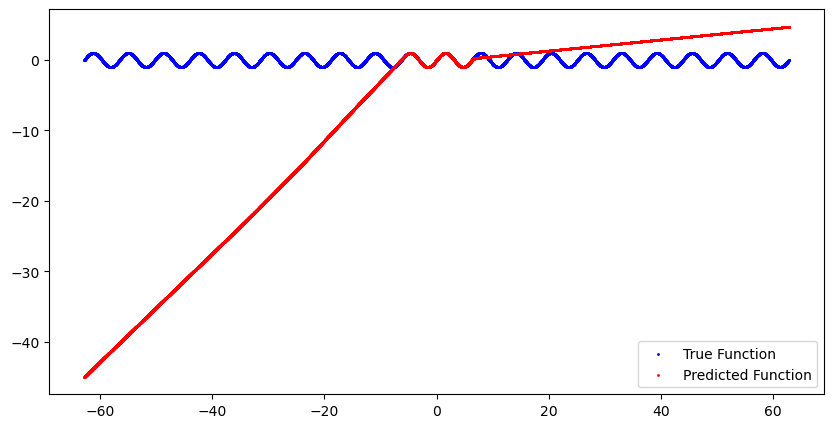

In [10]:
model.eval() # Switch model to evaluation mode (inference only)
# In `.eval()` mode dropout layers will not drop any neurons, and batch normalization layers will use running statistics instead of batch statistics

with torch.no_grad(): # Disable gradient calculation - less memory used, faster inference
    predicted = model(x_tensor).numpy() # Calculate predictions and convert them into numpy array

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.scatter(x, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()


Now we can see that outside of training range, model no longer approximates $sin(x)$ function.

# Using batches

Let's try training the same model on an extended data and for a longer time.

In this case we have 10x more data. So let's try to divide our data into batches and adjust weights after each batch instead of once per epoch. This approach should help at the start of training, because it is much easier for the model to learn just a few samples than all samples at once. We will also decrease learning rate to reduce influence of each batch on a model.

This approach will be slower because of frequent weights adjustment.

In [11]:
criterion = nn.MSELoss() # We use MSE (L2) for error calculation
optimizer = optim.Adam(model.parameters(), lr=0.001) # `model.parameters()` - model weights, lr - learning rate

In [12]:
dataset = TensorDataset(x_tensor, y_tensor) # we are creating dataset object from our data
batch_size = 16 # we will adjust weights after each 32 samples from training data
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # DataLoader object will shuffle dataset and read data by batches

In [13]:
# Training loop
epochs = 200
losses = [] # we will store losses from each epoch here for visualization purposes

for epoch in tqdm(range(epochs), desc="Epochs", ascii=True):
    model.train() # Switch model to training mode (enables dropout, changes batchnorm behavior)
    
    #for batch_x, batch_y in tqdm(dataloader, desc="Batches", leave=False): # Iterate over all batches during one epoch. tqdm is for progress bar.
    for batch_x, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_x) # Propagate input batch through the model to get outputs
        loss = criterion(outputs, batch_y) # Calculate the loss (error) by comparing model outputs to the true values in the batch
        
        # Backward pass and optimization
        optimizer.zero_grad() # Clear the gradients of all optimized tensors
        loss.backward() # Compute the gradient of the loss with respect to model parameters
        optimizer.step() # Update model parameters (weights and biases) using the optimizer
    
    losses.append(loss.item()) # Store the loss value for later analysis
    
    if (epoch + 1) % 100 == 0: # Print progress every 100 epochs (epochs count start from 0, so we add 1 for visualization)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epochs:  50%|##########################################                                          | 100/200 [01:06<01:07,  1.49it/s]

Epoch [100/200], Loss: 0.5368


Epochs: 100%|####################################################################################| 200/200 [02:12<00:00,  1.51it/s]

Epoch [200/200], Loss: 0.4360


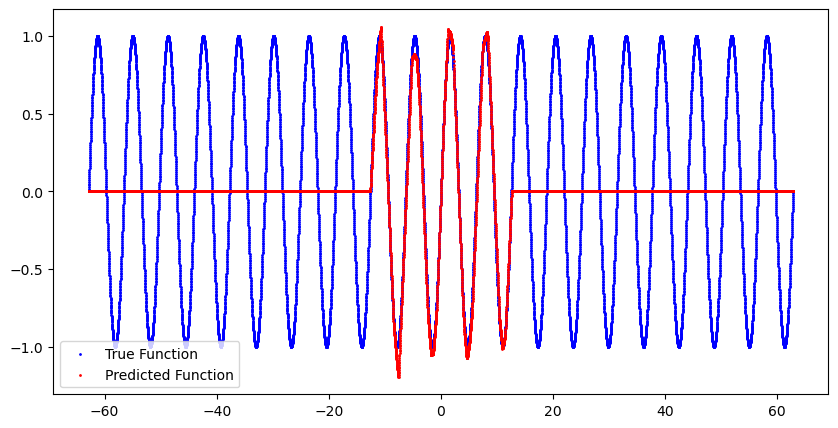

In [14]:
model.eval() # Switch model to evaluation mode (inference only)
# In `.eval()` mode dropout layers will not drop any neurons, and batch normalization layers will use running statistics instead of batch statistics

with torch.no_grad(): # Disable gradient calculation - less memory used, faster inference
    predicted = model(x_tensor).numpy() # Calculate predictions and convert them into numpy array

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.scatter(x, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()

In this case results are not good. Loss values are oscillating and not decreasing. We can see that model capacity is not enough to memorize all the values.

However the main reason is that model architecture is not suitable for periodic data. To solve this issue with current architecture, we either have to transform data into non-periodic with limited range or use periodic activation function.

# Using custom activation function

Defining custom activation function requires use of pytorch internal functionality:

In [16]:
# Define custom cosine activation function
def cos_activation(x):
    return torch.cos(x)

Now we can rebuild the model architecture with a custom activation function:

In [17]:
class SineNet(nn.Module):
    def __init__(self): # constructor
        super(SineNet, self).__init__()
        # In pytorch we need to explicitly state number of inputs and outputs for layer
        self.hidden1 = nn.Linear(1, 50) # one input and 50 outputs (neurons)
        self.hidden2 = nn.Linear(50, 25) # 50 inputs and 25 outputs (neurons)
        self.output = nn.Linear(25, 1) # 25 inputs and one output (neuron)

    def forward(self, x): # forward method to propagate signals through network
        x = cos_activation(self.hidden1(x))  # Use custom activation function
        x = cos_activation(self.hidden2(x))  # Use custom activation function
        x = self.output(x)
        return x

# Instantiate the model (from class create an object)
model = SineNet()

In [18]:
dataset = TensorDataset(x_tensor, y_tensor) # we are creating dataset object from our data
batch_size = 16 # we will adjust weights after each 32 samples from training data
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # DataLoader object will shuffle dataset and read data by batches

In [19]:
criterion = nn.MSELoss() # We use MSE (L2) for error calculation
optimizer = optim.Adam(model.parameters(), lr=0.001) # `model.parameters()` - model weights, lr - learning rate (set to 0.01)

In [20]:
# Training loop
epochs = 200
losses = [] # we will store losses from each epoch here for visualization purposes

for epoch in tqdm(range(epochs), desc="Epochs", ascii=True):
    model.train() # Switch model to training mode (enables dropout, changes batchnorm behavior)
    
    #for batch_x, batch_y in tqdm(dataloader, desc="Batches", leave=False): # Iterate over all batches during one epoch. tqdm is for progress bar.
    for batch_x, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_x) # Propagate input batch through the model to get outputs
        loss = criterion(outputs, batch_y) # Calculate the loss (error) by comparing model outputs to the true values in the batch
        
        # Backward pass and optimization
        optimizer.zero_grad() # Clear the gradients of all optimized tensors
        loss.backward() # Compute the gradient of the loss with respect to model parameters
        optimizer.step() # Update model parameters (weights and biases) using the optimizer
    
    losses.append(loss.item()) # Store the loss value for later analysis
    
    if (epoch + 1) % 100 == 0: # Print progress every 100 epochs (epochs count start from 0, so we add 1 for visualization)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epochs:  50%|##########################################                                          | 100/200 [01:06<01:07,  1.47it/s]

Epoch [100/200], Loss: 0.0001


Epochs: 100%|####################################################################################| 200/200 [02:12<00:00,  1.50it/s]

Epoch [200/200], Loss: 0.0000


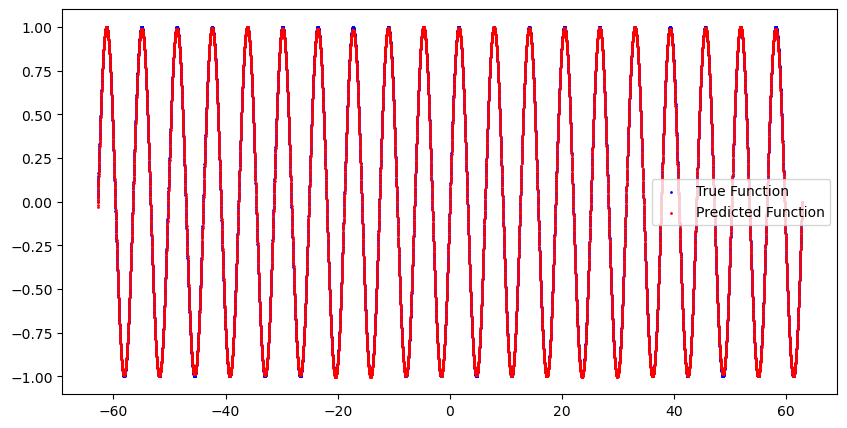

In [21]:
model.eval() # Switch model to evaluation mode (inference only)
# In `.eval()` mode dropout layers will not drop any neurons, and batch normalization layers will use running statistics instead of batch statistics

with torch.no_grad(): # Disable gradient calculation - less memory used, faster inference
    predicted = model(x_tensor).numpy() # Calculate predictions and convert them into numpy array

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.scatter(x, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()

Let's try to extend the range of data even more

In [22]:
# Generate additional data with extended range for evaluation of model generalization
x = np.linspace(-20000, -19900, 10000) # generate 10000 intermediate values equally spaced (input values)
y = np.sin(x) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_tensor = torch.Tensor(x).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (10000,) -> (10000,1)
y_tensor = torch.Tensor(y).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (10000,) -> (10000,1)

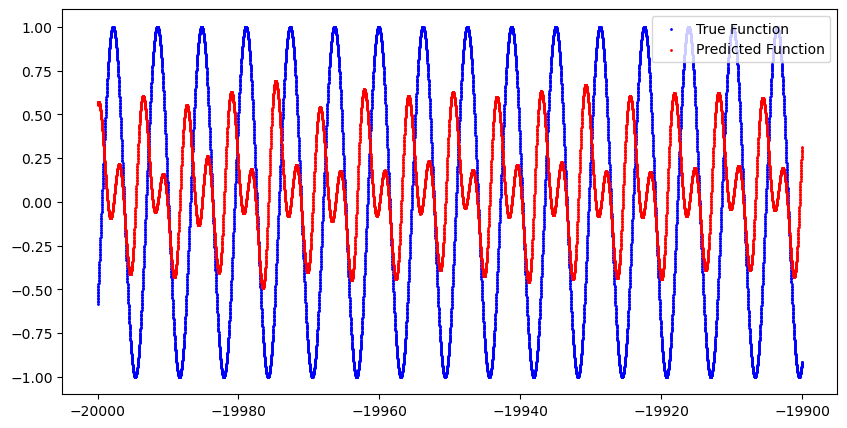

In [23]:
model.eval() # Switch model to evaluation mode (inference only)
# In `.eval()` mode dropout layers will not drop any neurons, and batch normalization layers will use running statistics instead of batch statistics

with torch.no_grad(): # Disable gradient calculation - less memory used, faster inference
    predicted = model(x_tensor).numpy() # Calculate predictions and convert them into numpy array

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.scatter(x, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()

# Pre-process data to make it non-periodic

We use a special activation function to transform periodic data to a limited range $[0; 2\pi)$

In [24]:
# radians % 2pi
class PreprocessXRadians(nn.Module):
    def forward(self, x):
        y = x % (2 * torch.pi)  # Element-wise modulo operation
        return y

In [26]:
class SineNet(nn.Module):
    def __init__(self): # constructor
        super(SineNet, self).__init__()
        # In pytorch we need to explicitly state number of inputs and outputs for layer
        self.hidden1 = nn.Linear(1, 50) # one input and 50 outputs (neurons)
        self.hidden2 = nn.Linear(50, 25) # 50 inputs and 25 outputs (neurons)
        self.output = nn.Linear(25, 1) # 25 inputs and one output (neuron)
        self.relu = nn.ReLU() # ReLU activation function
        self.custom_activation = PreprocessXRadians()
    
    def forward(self, x): # forward method to propagate signals through network
        x = self.custom_activation(x) # first transform data into limited range
        x = self.relu(self.hidden1(x)) # send input signal through hidden1() layer, then apply relu() function
        x = self.relu(self.hidden2(x)) # send output of previous layer through hidden2() layer, then apply relu() function
        x = self.output(x) # use result of previous operation as input to output layer (it has no activation function)
        return x

# Instantiate the model (from class create an object)
model = SineNet()

In [27]:
# Generate data
x = np.linspace(-2 * np.pi, 2 * np.pi, 1000) # generate 1000 intermediate values equally spaced (input values)
y = np.sin(x) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_tensor = torch.Tensor(x).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)
y_tensor = torch.Tensor(y).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)

In [28]:
dataset = TensorDataset(x_tensor, y_tensor) # we are creating dataset object from our data
batch_size = 16 # we will adjust weights after each 32 samples from training data
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # DataLoader object will shuffle dataset and read data by batches

In [29]:
criterion = nn.MSELoss() # We use MSE (L2) for error calculation
optimizer = optim.Adam(model.parameters(), lr=0.001) # `model.parameters()` - model weights, lr - learning rate (set to 0.01)

In [30]:
# Training loop
epochs = 200
losses = [] # we will store losses from each epoch here for visualization purposes

for epoch in tqdm(range(epochs), desc="Epochs", ascii=True):
    model.train() # Switch model to training mode (enables dropout, changes batchnorm behavior)
    
    #for batch_x, batch_y in tqdm(dataloader, desc="Batches", leave=False): # Iterate over all batches during one epoch. tqdm is for progress bar.
    for batch_x, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_x) # Propagate input batch through the model to get outputs
        loss = criterion(outputs, batch_y) # Calculate the loss (error) by comparing model outputs to the true values in the batch
        
        # Backward pass and optimization
        optimizer.zero_grad() # Clear the gradients of all optimized tensors
        loss.backward() # Compute the gradient of the loss with respect to model parameters
        optimizer.step() # Update model parameters (weights and biases) using the optimizer
    
    losses.append(loss.item()) # Store the loss value for later analysis
    
    if (epoch + 1) % 100 == 0: # Print progress every 100 epochs (epochs count start from 0, so we add 1 for visualization)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epochs:  51%|##########################################8                                         | 102/200 [00:07<00:06, 14.68it/s]

Epoch [100/200], Loss: 0.0002


Epochs: 100%|####################################################################################| 200/200 [00:13<00:00, 14.50it/s]

Epoch [200/200], Loss: 0.0000


In [31]:
# Generate additional data with extended range for evaluation of model generalization
x = np.linspace(-20000, -19900, 10000) # generate 10000 intermediate values equally spaced (input values)
y = np.sin(x) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_tensor = torch.Tensor(x).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (10000,) -> (10000,1)
y_tensor = torch.Tensor(y).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (10000,) -> (10000,1)

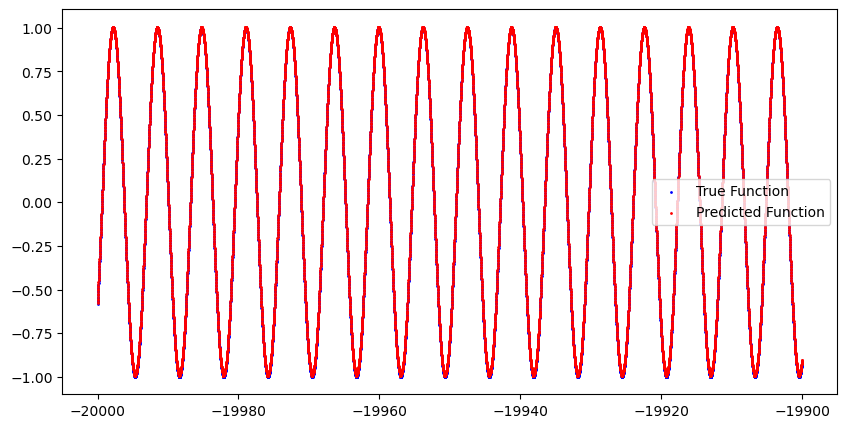

In [32]:
model.eval() # Switch model to evaluation mode (inference only)
# In `.eval()` mode dropout layers will not drop any neurons, and batch normalization layers will use running statistics instead of batch statistics

with torch.no_grad(): # Disable gradient calculation - less memory used, faster inference
    predicted = model(x_tensor).numpy() # Calculate predictions and convert them into numpy array

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.scatter(x, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()

From these results we can draw conclusions:
* Model is more efficient at learning limited range of data
* Transform all input data into a limited range, so model can learn it well
* Model can approximate periodic data if period is known:
  * Periodic activation function is used
  * Data preprocessed into to a non-periodic with a limited range
* Even with periodic activation function, small model training errors may lead to a huge deviation at extended range
* Either use custom activation at the input of model or pre-process data externally

$f(x)=2sin(x)+cos(2x)$

In [33]:
# Generate data
x = np.linspace(-2 * np.pi, 2 * np.pi, 10000) # generate 10000 intermediate values equally spaced (input values)
y = 2*np.sin(x)+np.cos(2*x) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_tensor = torch.Tensor(x).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)
y_tensor = torch.Tensor(y).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)

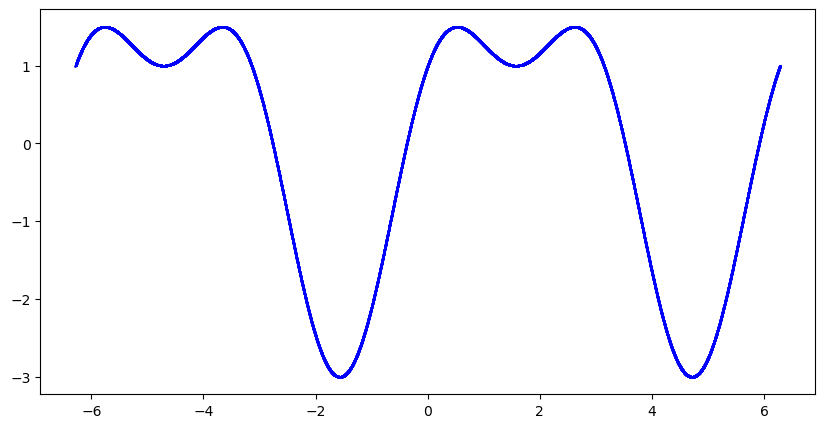

In [34]:
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.show()

In [35]:
# radians % 2pi
class PreprocessXRadians(nn.Module):
    def forward(self, x):
        y = x % (2 * torch.pi)  # Element-wise modulo operation
        return y

In [36]:
class SineNet(nn.Module):
    def __init__(self): # constructor
        super(SineNet, self).__init__()
        # In pytorch we need to explicitly state number of inputs and outputs for layer
        self.hidden1 = nn.Linear(1, 50) # one input and 50 outputs (neurons)
        self.hidden2 = nn.Linear(50, 25) # 50 inputs and 25 outputs (neurons)
        self.output = nn.Linear(25, 1) # 25 inputs and one output (neuron)
        self.relu = nn.ReLU() # ReLU activation function
        self.custom_activation = PreprocessXRadians()
    
    def forward(self, x): # forward method to propagate signals through network
        x = self.custom_activation(x) # first transform data into limited range
        x = self.relu(self.hidden1(x)) # send input signal through hidden1() layer, then apply relu() function
        x = self.relu(self.hidden2(x)) # send output of previous layer through hidden2() layer, then apply relu() function
        x = self.output(x) # use result of previous operation as input to output layer (it has no activation function)
        return x

# Instantiate the model (from class create an object)
model = SineNet()

In [37]:
dataset = TensorDataset(x_tensor, y_tensor) # we are creating dataset object from our data
batch_size = 16 # we will adjust weights after each 32 samples from training data
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # DataLoader object will shuffle dataset and read data by batches

In [39]:
criterion = nn.MSELoss() # We use MSE (L2) for error calculation
optimizer = optim.Adam(model.parameters(), lr=0.1) # `model.parameters()` - model weights, lr - learning rate (set to 0.01)
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)  # Exponential decay rate (next rate = current rate * 0.99)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100)#, verbose=True)

In [40]:
# Training loop
epochs = 200
losses = [] # we will store losses from each epoch here for visualization purposes

for epoch in tqdm(range(epochs), desc="Epochs", ascii=True):
    model.train()
    
    batch_losses = []
    for batch_x, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    
    epoch_loss = np.mean(batch_losses)
    losses.append(epoch_loss)
    
    # Step the scheduler to adjust the learning rate
    #scheduler.step()
    scheduler.step(epoch_loss)
    
    # Print the current learning rate
    current_lr = scheduler.get_last_lr()[0]
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Learning Rate: {current_lr:.6f}')


Epochs:  50%|##########################################                                          | 100/200 [01:06<01:06,  1.50it/s]

Epoch [100/200], Loss: 0.0390, Learning Rate: 0.100000


Epochs: 100%|####################################################################################| 200/200 [02:12<00:00,  1.50it/s]

Epoch [200/200], Loss: 0.0225, Learning Rate: 0.050000


In [41]:
# Generate additional data with extended range for evaluation of model generalization
x = np.linspace(-20000, -19900, 10000) # generate 10000 intermediate values equally spaced (input values)
y = 2*np.sin(x)+np.cos(2*x) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_tensor = torch.Tensor(x).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (10000,) -> (10000,1)
y_tensor = torch.Tensor(y).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (10000,) -> (10000,1)

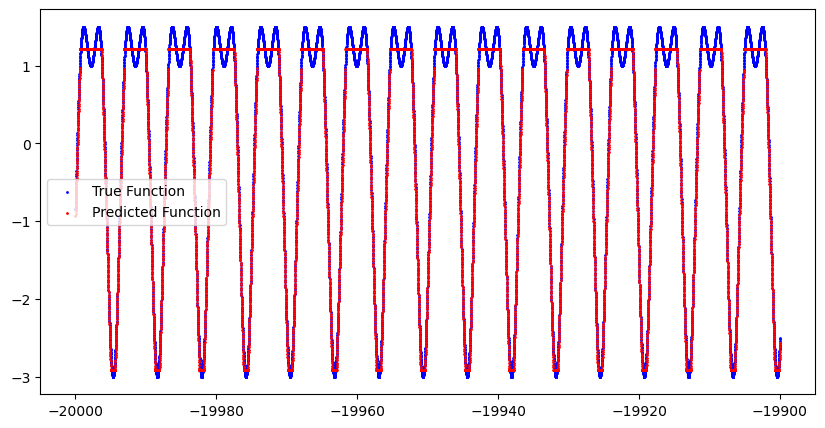

In [42]:
model.eval() # Switch model to evaluation mode (inference only)
# In `.eval()` mode dropout layers will not drop any neurons, and batch normalization layers will use running statistics instead of batch statistics

with torch.no_grad(): # Disable gradient calculation - less memory used, faster inference
    predicted = model(x_tensor).numpy() # Calculate predictions and convert them into numpy array

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.scatter(x, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()

---

---

### Training Stages in Deep Learning
Training a deep learning model effectively requires a staged approach. This is because it's often impossible for an optimization algorithm to find a solution that fits all the data at once.

Main stages:

* Pre-training
    * Purpose: To perform an initial adjustment of the model weights.
    * Data: Use a very limited range of data (1/100 or less of all data, simple samples or/and limited range).
    * Advantages: Fast and easy training.
* Intermediate Training
    * Purpose: To refine the model further with a larger dataset.
    * Data: Use a dataset that is larger than that used in pre-training (about 1/10 of all data, more compelx samples or/and extended range).
    * Advantages: Allows the model to learn from more diverse examples, improving its accuracy and robustness.
* Final Training
    * Purpose: To achieve the best possible performance.
    * Data: Use a full training dataset.
    * Advantages: Although this is the slowest training step, it ensures that the model has learned from a comprehensive and extensive range of data.
 
### Optimizer and Scheduler Management
* State Retention: The state of the optimizer and scheduler will be maintained across stages.
* The learning rate will progressively decrease with each stage. This helps the model fine-tune its weights more precisely as it is exposed to larger datasets.

This structure helps in gradually increasing the complexity and amount of data the model is exposed to, while also managing the learning rate to ensure optimal training performance and generalization.

We will start from custo activation function and model definition

In [43]:
# Define custom cosine activation function
def cos_activation(x):
    return torch.cos(x)

In [44]:
class SineNet(nn.Module):
    def __init__(self): # constructor
        super(SineNet, self).__init__()
        # In pytorch we need to explicitly state number of inputs and outputs for each layer
        self.hidden1 = nn.Linear(1, 5)
        # These 3 hidden layers look the same, but we still need to define all of them as we don't want to share the weights
        self.hidden2 = nn.Linear(5, 5)
        self.hidden3 = nn.Linear(5, 5)
        self.hidden4 = nn.Linear(5, 5)
        self.output = nn.Linear(5, 1)

    def forward(self, x): # forward method to propagate signals through network
        # Here we perform connection of layers
        x = cos_activation(self.hidden1(x))
        x = cos_activation(self.hidden2(x))
        x = cos_activation(self.hidden3(x))
        x = cos_activation(self.hidden4(x))
        x = self.output(x)
        return x

# Instantiate the model (from class create an object)
model = SineNet()

### Model Training Configuration
In this section, we will define how the loss (error) will be calculated, the optimizer to use, and the scheduler to adjust the learning rate.

* Loss Calculation
    * Definition: The loss function measures the difference between the predicted values and the actual values. This error is what the optimizer seeks to minimize.
    * Common Choices:
        * For classification tasks: Cross-Entropy Loss
        * For regression tasks: Mean Squared Error (MSE) or Mean Absolute Error (MAE)
* Optimizer
    * Purpose: The optimizer adjusts the model parameters (weights) to minimize the loss.
    * Common Choices:
        * Stochastic Gradient Descent (SGD): A basic optimizer that can be enhanced with momentum.
        * Adam (Adaptive Moment Estimation): An optimizer that combines the advantages of two other extensions of stochastic gradient descent. It computes adaptive learning rates for each parameter.
        * RMSprop (Root Mean Square Propagation): An optimizer well-suited for recurrent neural networks.
* Learning Rate Scheduler
    * Purpose: The scheduler adjusts the learning rate during training to improve convergence.
    * Common Choices:
        * StepLR: Decays the learning rate by a factor every few epochs.
        * ExponentialLR: Decays the learning rate exponentially.
        * ReduceLROnPlateau: Reduces the learning rate when a metric has stopped improving.

This will be the main training function

In [45]:
def train_model(model, epochs, dataloader, optimizer, scheduler, criterion):
    """
    Trains the given model using the provided dataloader, optimizer, scheduler, and criterion.
    
    Parameters:
    - model: The model to be trained.
    - epochs: The number of epochs for training.
    - dataloader: The DataLoader providing the training data.
    - optimizer: The optimizer.
    - scheduler: The learning rate scheduler.
    - criterion: The loss function.
    
    Returns:
    - model: The trained model with the best parameters.
    - optimizer: The optimizer with its state.
    - scheduler: The scheduler with its state.
    - losses: A list of average losses for each epoch.
    """
    losses = []  # Store losses from each epoch for visualization purposes
    best_loss = float('inf')
    best_model_state = None

    for epoch in tqdm(range(epochs), desc="Epochs", ascii=True):
        model.train()
        
        batch_losses = []
        for batch_x, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        epoch_loss = np.mean(batch_losses)
        losses.append(epoch_loss)

        # Save the best model state
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_state = model.state_dict()
            
        # Step the scheduler to adjust the learning rate
        scheduler.step(epoch_loss)
        
        # Print the current learning rate
        current_lr = scheduler.get_last_lr()[0]
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.8f}, Learning Rate: {current_lr:.8f}')

    # Load the best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Best loss: {best_loss:.8f}")

    return model, optimizer, scheduler, losses

Plotting losses will help to understand the state of training

In [46]:
def plot_losses(losses, title="Training Loss Over Epochs", max_loss=1):
    """
    Plots the training losses over epochs.

    Parameters:
    - losses: List of losses recorded at each epoch.
    - title: The title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    #plt.xlim(left=x_start)
    plt.ylim(0, max_loss)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

Let's define model loss/error evaluation criterion and lerning rate adjustment scheduler

In [47]:
criterion = nn.MSELoss() # We use MSE (L2) for error calculation

# SGD
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# RMSprop
#optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)
# AdamW
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01) # `model.parameters()` - model weights, lr - learning rate (set to 0.01)
# Adam
#optimizer = optim.Adam(model.parameters(), lr=0.01) # `model.parameters()` - model weights, lr - learning rate (set to 0.01)

# Exponential learning rate decay
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)  # next rate = current rate * 0.99
# Reduce learning rate on plateau
# If no improvement in 100 epochs lr = lr * 0.5
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=100)

### Data for visual evaluation

For evaluation we will take data outside of training range

In [48]:
# Generate data with extended range for visual evaluation of model generalization
x_eval = np.linspace(-20000, -19990, 1000) # generate 1000 intermediate values equally spaced (input values)
y_eval = 2*np.sin(x_eval)+np.cos(2*x_eval) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_eval_tensor = torch.Tensor(x_eval).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)
y_eval_tensor = torch.Tensor(y_eval).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)

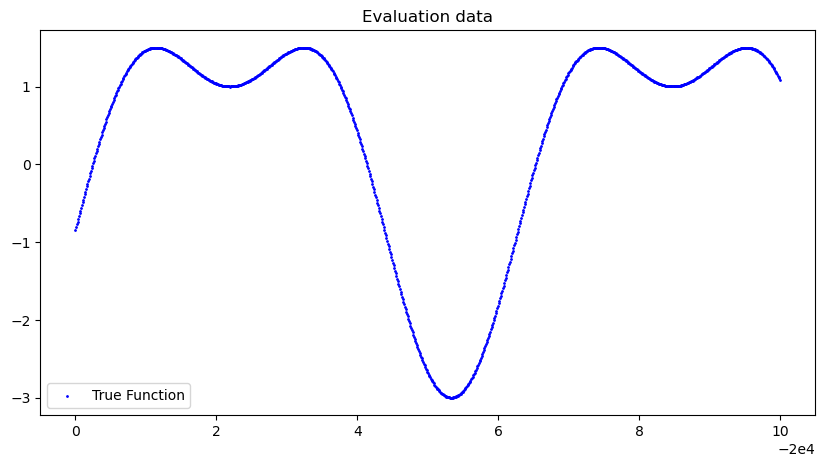

In [49]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.title("Evaluation data")
plt.scatter(x_eval, y_eval, label='True Function', color='blue', s=1)
plt.legend()
plt.show()

### Pre-training stage

Because we are using periodic activation functions and our data is also periodic. We can reach quite good results in the pre-training stage if we get the loss very close to 0.

In [50]:
# Generate pre-training data
x = np.linspace(-2 * np.pi, 2 * np.pi, 2000) # Use this for initial fast training (pre-training)
#x = np.linspace(-20 * np.pi, 20 * np.pi, 10000) # Use this for intermediate training (only after model fits well the previous data)
#x = np.linspace(-200 * np.pi, 200 * np.pi, 100000) # Use this for final training (the slowest)
y = 2*np.sin(x)+np.cos(2*x) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_tensor = torch.Tensor(x).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)
y_tensor = torch.Tensor(y).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)

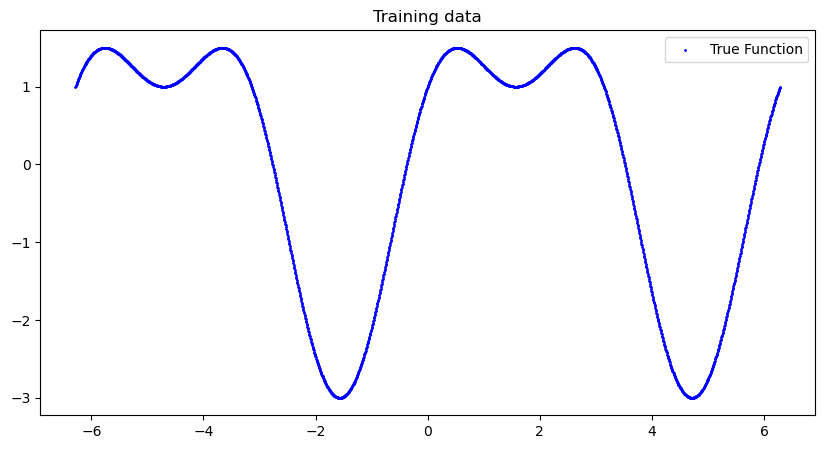

In [51]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.title("Training data")
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.legend()
plt.show()

Dataset object will allow to shuffle and feed data in batches

In [52]:
dataset = TensorDataset(x_tensor, y_tensor) # we are creating dataset object from our data
batch_size = 64 # we will adjust weights after each batch_size samples from training data
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # DataLoader object will shuffle dataset and read data by batches

In [61]:
# Training loop
epochs = 1000
model, optimizer, scheduler, losses = train_model(model, epochs, dataloader, optimizer, scheduler, criterion)

Epochs:  10%|########4                                                                          | 102/1000 [00:06<00:53, 16.69it/s]

Epoch [100/1000], Loss: 0.00002229, Learning Rate: 0.00125000


Epochs:  20%|################7                                                                  | 202/1000 [00:11<00:47, 16.63it/s]

Epoch [200/1000], Loss: 0.00000806, Learning Rate: 0.00062500


Epochs:  30%|#########################                                                          | 302/1000 [00:17<00:41, 16.84it/s]

Epoch [300/1000], Loss: 0.00000699, Learning Rate: 0.00062500


Epochs:  40%|#################################3                                                 | 402/1000 [00:23<00:35, 16.67it/s]

Epoch [400/1000], Loss: 0.00000516, Learning Rate: 0.00031250


Epochs:  50%|#########################################6                                         | 502/1000 [00:29<00:28, 17.23it/s]

Epoch [500/1000], Loss: 0.00000618, Learning Rate: 0.00031250


Epochs:  60%|#################################################9                                 | 602/1000 [00:35<00:24, 16.43it/s]

Epoch [600/1000], Loss: 0.00000432, Learning Rate: 0.00031250


Epochs:  70%|##########################################################2                        | 702/1000 [00:41<00:17, 16.58it/s]

Epoch [700/1000], Loss: 0.00000404, Learning Rate: 0.00031250


Epochs:  80%|##################################################################5                | 802/1000 [00:47<00:11, 16.86it/s]

Epoch [800/1000], Loss: 0.00000419, Learning Rate: 0.00031250


Epochs:  90%|##########################################################################8        | 902/1000 [00:53<00:06, 16.24it/s]

Epoch [900/1000], Loss: 0.00000389, Learning Rate: 0.00015625


Epochs: 100%|##################################################################################| 1000/1000 [00:59<00:00, 16.80it/s]

Epoch [1000/1000], Loss: 0.00000305, Learning Rate: 0.00015625
Best loss: 0.00000286


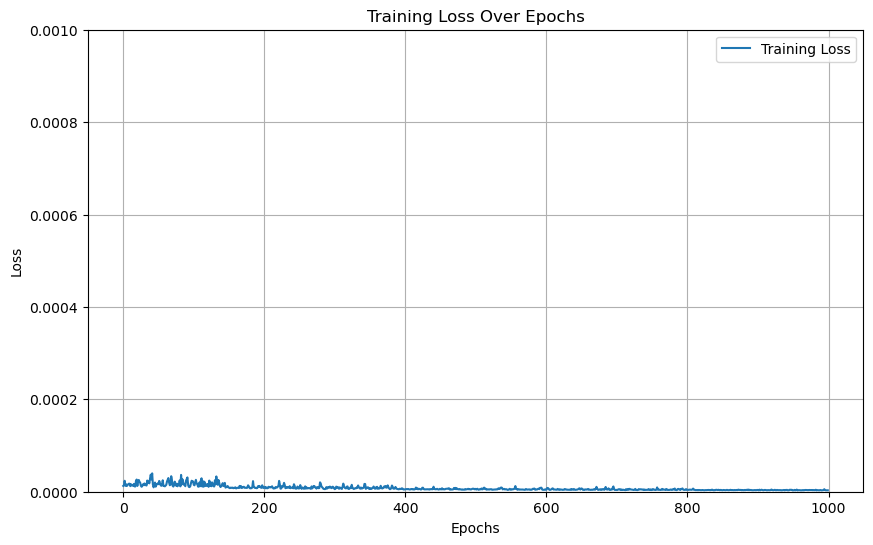

In [62]:
plot_losses(losses, max_loss=0.001) # limit max loss to better see the end of training

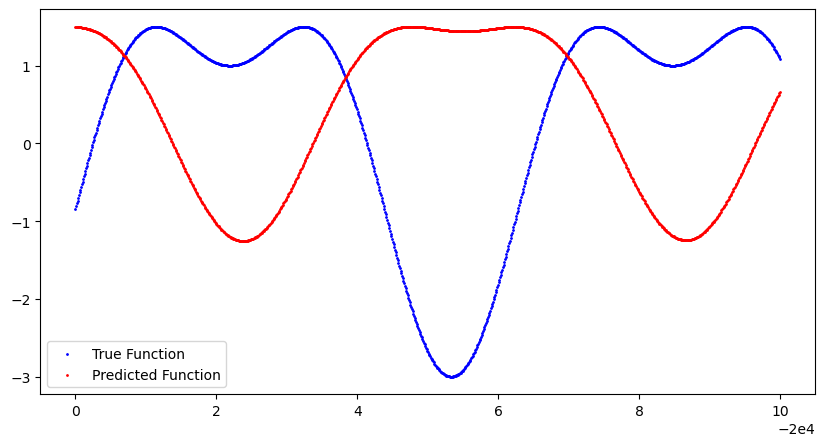

In [63]:
model.eval() # Switch model to evaluation mode (inference only)
# In `.eval()` mode dropout layers will not drop any neurons, and batch normalization layers will use running statistics instead of batch statistics

with torch.no_grad(): # Disable gradient calculation - less memory used, faster inference
    predicted = model(x_eval_tensor).numpy() # Calculate predictions and convert them into numpy array

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x_eval, y_eval, label='True Function', color='blue', s=1)
plt.scatter(x_eval, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()

### Intermediate training

In [64]:
# Generate pre-training data
#x = np.linspace(-2 * np.pi, 2 * np.pi, 1000) # Use this for initial fast training (pre-training)
x = np.linspace(-20 * np.pi, 20 * np.pi, 10000) # Use this for intermediate training (only after model fits well the previous data)
#x = np.linspace(-200 * np.pi, 200 * np.pi, 100000) # Use this for final training (the slowest)
y = 2*np.sin(x)+np.cos(2*x) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_tensor = torch.Tensor(x).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)
y_tensor = torch.Tensor(y).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)

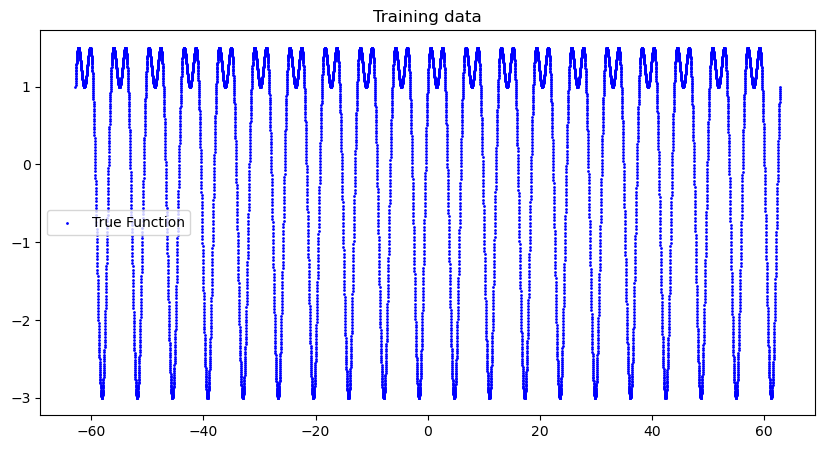

In [65]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.title("Training data")
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.legend()
plt.show()

In [66]:
dataset = TensorDataset(x_tensor, y_tensor) # we are creating dataset object from our data
batch_size = 64 # we will adjust weights after each batch_size samples from training data
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # DataLoader object will shuffle dataset and read data by batches

In [67]:
# Training loop
epochs = 500
model, optimizer, scheduler, losses = train_model(model, epochs, dataloader, optimizer, scheduler, criterion)

Epochs:  20%|################8                                                                   | 100/500 [00:28<01:53,  3.52it/s]

Epoch [100/500], Loss: 0.00000283, Learning Rate: 0.00007813


Epochs:  40%|#################################6                                                  | 200/500 [00:56<01:25,  3.51it/s]

Epoch [200/500], Loss: 0.00000229, Learning Rate: 0.00007813


Epochs:  60%|##################################################4                                 | 300/500 [01:25<00:57,  3.51it/s]

Epoch [300/500], Loss: 0.00000228, Learning Rate: 0.00007813


Epochs:  80%|###################################################################2                | 400/500 [01:54<00:28,  3.55it/s]

Epoch [400/500], Loss: 0.00000209, Learning Rate: 0.00007813


Epochs: 100%|####################################################################################| 500/500 [02:22<00:00,  3.51it/s]

Epoch [500/500], Loss: 0.00000190, Learning Rate: 0.00007813
Best loss: 0.00000179


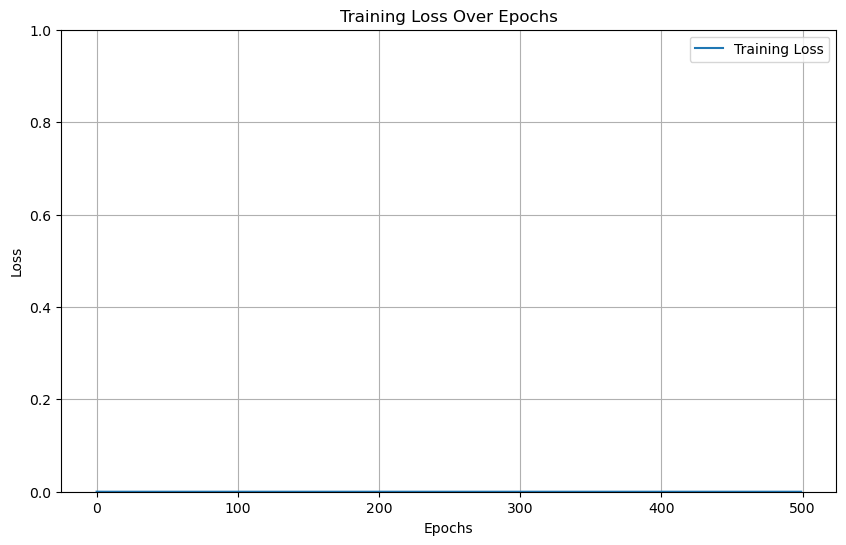

In [68]:
plot_losses(losses)

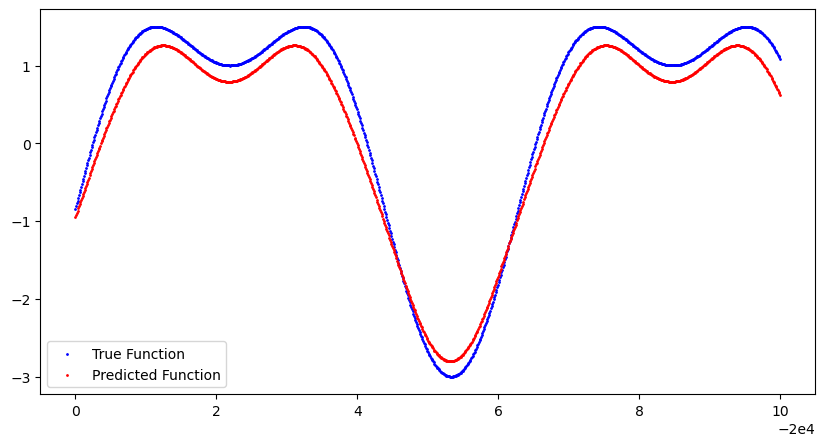

In [69]:
model.eval() # Switch model to evaluation mode (inference only)
# In `.eval()` mode dropout layers will not drop any neurons, and batch normalization layers will use running statistics instead of batch statistics

with torch.no_grad(): # Disable gradient calculation - less memory used, faster inference
    predicted = model(x_eval_tensor).numpy() # Calculate predictions and convert them into numpy array

# Plotting the results
plt.figure(figsize=(10, 5))
plt.scatter(x_eval, y_eval, label='True Function', color='blue', s=1)
plt.scatter(x_eval, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()

### Final training

In [70]:
# Generate pre-training data
#x = np.linspace(-2 * np.pi, 2 * np.pi, 1000) # Use this for initial fast training (pre-training)
#x = np.linspace(-20 * np.pi, 20 * np.pi, 10000) # Use this for intermediate training (only after model fits well the previous data)
x = np.linspace(-200 * np.pi, 200 * np.pi, 100000) # Use this for final training (the slowest)
y = 2*np.sin(x)+np.cos(2*x) # our goal function (output values)

# Convert to PyTorch tensors so it could be used by pytorch
x_tensor = torch.Tensor(x).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)
y_tensor = torch.Tensor(y).unsqueeze(1) # unsqueeze(1) will add one dimension to tensor, (1000,) -> (1000,1)

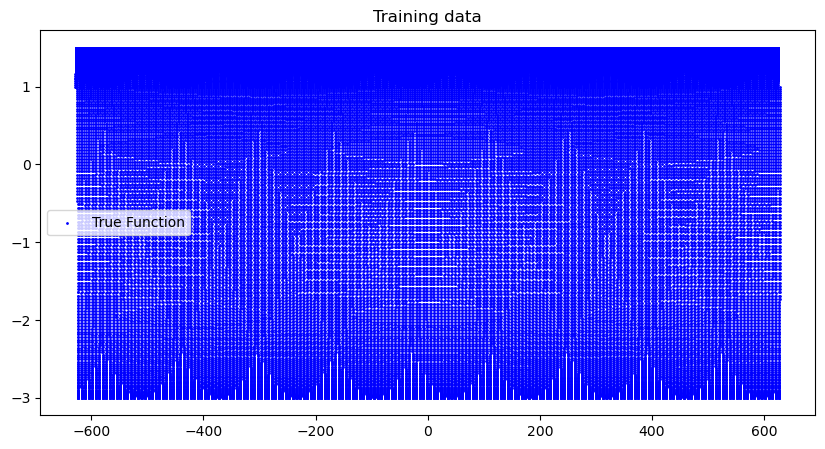

In [71]:
# Plotting the data
plt.figure(figsize=(10, 5))
plt.title("Training data")
plt.scatter(x, y, label='True Function', color='blue', s=1)
plt.legend()
plt.show()

In [72]:
dataset = TensorDataset(x_tensor, y_tensor) # we are creating dataset object from our data
batch_size = 64 # we will adjust weights after each batch_size samples from training data
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) # DataLoader object will shuffle dataset and read data by batches

In [73]:
# Training loop
epochs = 500
model, optimizer, scheduler, losses = train_model(model, epochs, dataloader, optimizer, scheduler, criterion)

Epochs:  20%|################8                                                                   | 100/500 [04:43<18:32,  2.78s/it]

Epoch [100/500], Loss: 0.00000620, Learning Rate: 0.00003906


Epochs:  40%|#################################6                                                  | 200/500 [09:21<13:56,  2.79s/it]

Epoch [200/500], Loss: 0.00000256, Learning Rate: 0.00001953


Epochs:  60%|##################################################4                                 | 300/500 [14:03<09:23,  2.82s/it]

Epoch [300/500], Loss: 0.00000180, Learning Rate: 0.00001953


Epochs:  80%|###################################################################2                | 400/500 [18:40<04:37,  2.77s/it]

Epoch [400/500], Loss: 0.00000177, Learning Rate: 0.00001953


Epochs: 100%|####################################################################################| 500/500 [23:18<00:00,  2.80s/it]

Epoch [500/500], Loss: 0.00000137, Learning Rate: 0.00001953
Best loss: 0.00000124


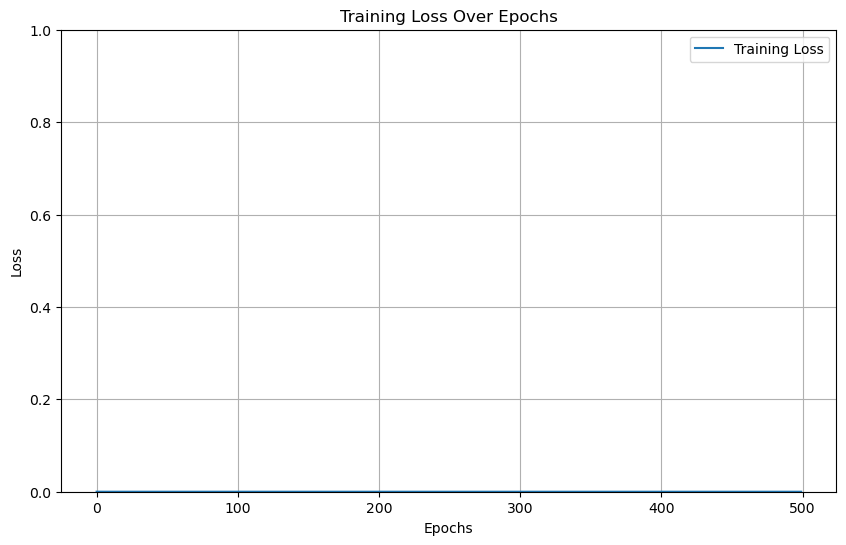

In [74]:
plot_losses(losses)

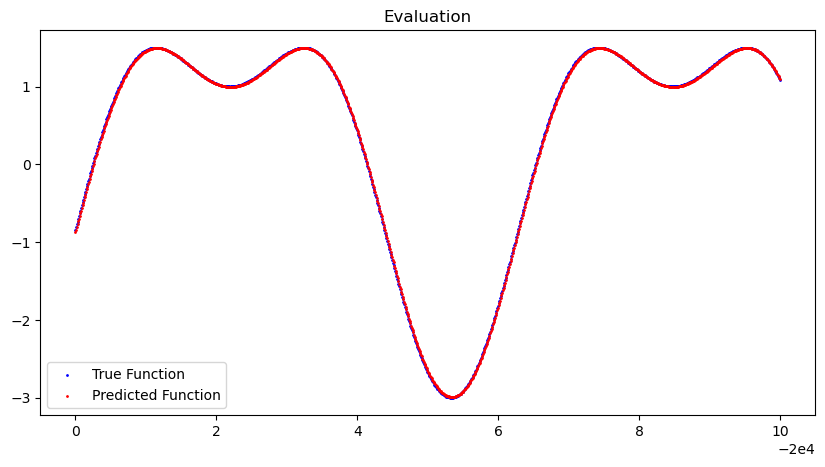

In [75]:
model.eval() # Switch model to evaluation mode (inference only)
# In `.eval()` mode dropout layers will not drop any neurons, and batch normalization layers will use running statistics instead of batch statistics

with torch.no_grad(): # Disable gradient calculation - less memory used, faster inference
    predicted = model(x_eval_tensor).numpy() # Calculate predictions and convert them into numpy array

# Plotting the results
plt.figure(figsize=(10, 5))
plt.title("Evaluation")
plt.scatter(x_eval, y_eval, label='True Function', color='blue', s=1)
plt.scatter(x_eval, predicted, label='Predicted Function', color='red', s=1)
plt.legend()
plt.show()